In [2]:
from scipy.signal import convolve2d
from skimage.feature import canny
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [13]:
from skimage.filters import gaussian, threshold_local
from skimage.transform import hough_line, probabilistic_hough_line
from collections import Counter
from skimage.morphology import binary_closing, binary_opening, binary_erosion, binary_dilation
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage import draw

In [3]:
def gray_img(img):
    gray = rgb2gray(img)
    if len(img.shape) == 3:
        gray = gray*255
    return gray

In [4]:
def otsu(img):
    blur = gaussian(img)
    otsu_bin = 255*(blur > threshold_otsu(blur))
    return (otsu_bin/255).astype(np.int32)

In [5]:
def rle_encode(x, dropna=False):
    where = np.flatnonzero
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return (np.array([], dtype=int),
                np.array([], dtype=int),
                np.array([], dtype=x.dtype))

    starts = np.r_[0, where(~np.isclose(x[1:], x[:-1], equal_nan=True)) + 1]
    lengths = np.diff(np.r_[starts, n])
    values = x[starts]

    if dropna:
        mask = ~np.isnan(values)
        starts, lengths, values = starts[mask], lengths[mask], values[mask]

    return starts, lengths, values


In [6]:
def rle_img(img, axis=1):
    if axis == 1:
        rle = [rle_encode(img[:, i])[1] for i in range(img.shape[1])]
        values = [rle_encode(img[:, i])[2] for i in range(img.shape[1])]
        return rle, values
    else:
        rle = [rle_encode(img[i])[1] for i in range(img.shape[0])]
        values = [rle_encode(img[i])[2] for i in range(img.shape[0])]
        return rle, values


In [7]:
def get_consecutive_sum(arr):
    n = len(arr)
    if n == 1:
        return list(arr)
    elif n % 2 == 0:
        return [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
    else:
        result = [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
        result.append(arr[-2] + arr[-1])
        return result


In [8]:
def get_most_common(rle):
    consecutive_sum = [get_consecutive_sum(column) for column in rle]

    flat_structure = []
    for column_data in consecutive_sum:
        flat_structure += column_data

    most_common = np.argmax(np.bincount(flat_structure))
    return most_common


In [9]:
def get_sum_components(arr, most_common):
    n = len(arr)
    if n == 1:
        return []
    elif n % 2 == 0:
        return [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2) if arr[i] + arr[i + 1] == most_common]
    else:
        result = [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2) if arr[i] + arr[i + 1] == most_common]
        if arr[-2] + arr[-1] == most_common:
            result.append((arr[-2], arr[-1]))
        return result


In [10]:
def get_thickness_spacing(rle, m_c=None):
    if m_c is None:
        m_c = get_most_common(rle)

    sum_components = [get_sum_components(column, m_c) for column in rle]
    sum_components = [x for x in sum_components if x]

    flat_sum_structure = []
    for column_data in sum_components:
        flat_sum_structure += column_data

    counter = Counter(flat_sum_structure)
    pair, count = counter.most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing, counter


In [11]:
def rl_decode(starts, lengths, values, minlength=None):
    starts, lengths, values = map(np.asarray, (starts, lengths, values))
    ends = starts + lengths
    n = ends[-1]
    if minlength is not None:
        n = max(minlength, n)
    x = np.full(n, np.nan)
    for lo, hi, val in zip(starts, ends, values):
        x[lo:hi] = val
    return x

def rl_decode_2D(rle, values, output_shape, axis=1):
    starts = [[int(np.sum(arr[:i])) for i in range(len(arr))] for arr in rle]

    decoded = np.zeros(output_shape, dtype=np.int32)
    if axis == 1:
        for i in range(decoded.shape[1]):
            decoded[:, i] = rl_decode(starts[i], rle[i], values[i])
    else:
        for i in range(decoded.shape[0]):
            decoded[i] = rl_decode(starts[i], rle[i], values[i])

    return decoded


In [12]:
def remove_black_blocks(arr, values, max_block_height):
    marked_arr = [[arr[i], 'w' if val == 1 else 'b'] for i, val in enumerate(values)]
    for elem in marked_arr:
        if elem[1] == 'b' and elem[0] < max_block_height:
            elem[1] = 'w'

    result, vals = [], []
    next_elem = 0
    for elem in marked_arr:
        if elem[1] == 'w':
            next_elem += elem[0]
        else:
            if next_elem:
                result.append(next_elem)
                vals.append(1)
            result.append(elem[0])
            vals.append(0)
            next_elem = 0
    if next_elem:
        result.append(next_elem)
        vals.append(1)

    return result, vals

def remove_h_lines(img, line_thickness):
    rle, values = rle_img(img)
    filtered_rle, new_values = [], []
    for i in range(len(rle)):
        res, val = remove_black_blocks(rle[i], values[i], 2 * line_thickness)
        filtered_rle.append(res)
        new_values.append(val)

    return rl_decode_2D(filtered_rle, new_values, img.shape)


def remove_v_lines(img, line_thickness):
    rle, values = rle_img(img, axis=0)
    filtered_rle, new_values = [], []
    for i in range(len(rle)):
        res, val = remove_black_blocks(rle[i], values[i], 2 * line_thickness)
        filtered_rle.append(res)
        new_values.append(val)

    return rl_decode_2D(filtered_rle, new_values, img.shape, axis=0)


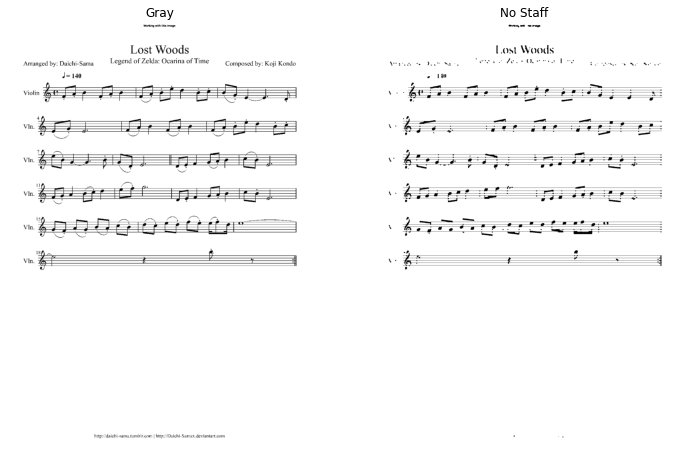

In [14]:
img = io.imread('dataset/lost.png')
gray = gray_img(img)
bin_img = otsu(gray)
# show_images([gray, bin_img], ['Gray', 'Binary'])

rle, vals = rle_img(bin_img)
most_common = get_most_common(rle)
thickness, spacing, _ = get_thickness_spacing(rle, most_common)

no_h_staff = remove_h_lines(bin_img, thickness)
no_v_staff = remove_v_lines(no_h_staff, thickness)

canny_img = 255 - 255*(abs(gray-no_h_staff)).astype(np.uint8)
edges = canny(canny_img, sigma=0.5, low_threshold=50, high_threshold=250)
# show_images([canny_img, edges], ['Canny Image', 'Edges'])
lines = probabilistic_hough_line(255-gray, threshold=edges.shape[1]//2)
# print(lines)

filtered_lines = []
lines = sorted(lines, key=lambda l : l[0][1])
for index, line in enumerate(lines):
    if index > 0 and (line[0][1] - filtered_lines[-1][0][1] < 0.9*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        filtered_lines.append(line)
        rr, cc = draw.line(x0, y0, x1, y0)
        # print(rr, cc)
        no_v_staff[cc, rr] = 0
show_images([gray, no_v_staff], ['Gray', 'No Staff'])
# inv_bin = 255 - bin_img
# show_images([inv_bin], ['Inverted'])


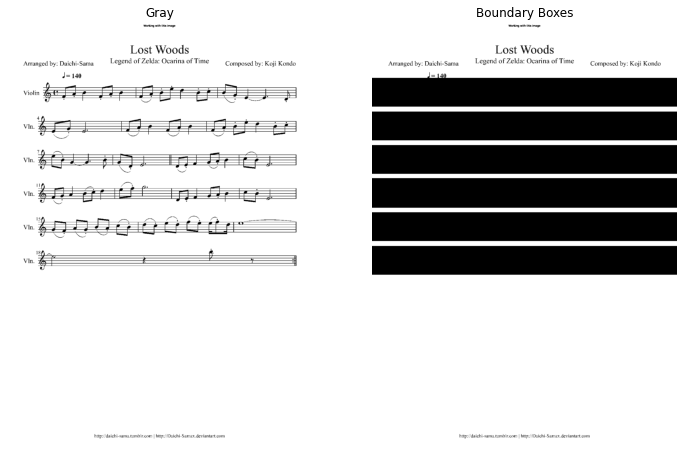

In [15]:
top_bottom_lines = []
for index, line in enumerate(filtered_lines):
    if index > 0 and (line[0][1] - top_bottom_lines[-1][1] < 4*spacing):
        pass
    else:
        p1, p2 = line
        x0, y0 = p1
        x1, y1 = p2
        top_bottom_lines.append((x0, y0, x1, y1))

consec_dists = []
for i in range(len(top_bottom_lines)-1):
    consec_dists.append(top_bottom_lines[i+1][1] - top_bottom_lines[i][1])

max_spacing = max(consec_dists)
box_margin = max_spacing//2

centers = []
for i in range(0, len(top_bottom_lines)-1, 2):
    center = (top_bottom_lines[i+1][1] - top_bottom_lines[i][1])//2
    center_y = top_bottom_lines[i][1] + center
    centers.append((center_y, center))

display_margin = max_spacing // 10
roi = []
bboxes = np.copy(gray)
for index, (center, offset) in enumerate(centers):
    top = int(center) - box_margin - offset + display_margin
    bottom = int(center) + box_margin + offset - display_margin
    roi.append((top, bottom))
    rr, cc = draw.rectangle(start = (top, 0), end = (bottom,bboxes.shape[1]), shape=bboxes.shape)
    bboxes[rr, cc] = 0

show_images([gray, bboxes], ['Gray', 'Boundary Boxes'])

In [191]:
clef_imgs = {
    "treble": [io.imread('dataset/treble_1.jpg'), io.imread('dataset/treble_2.jpg')],
    "bass": [io.imread('dataset/bass_1.jpg')]
}

for clef in clef_imgs:
    